In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import models, transforms
from data_generator import show_results
from utils import SquareNet, ImageDataset

## Let's load the data and the model

In [2]:
data = np.load("square_dataset.npz", allow_pickle=True, encoding="latin1")
X = data['X']
Y = data['Y']
dataset = ImageDataset(X,Y)

model = SquareNet()
model.load_state_dict(torch.load('net.pt'))
model.eval()

SquareNet(
  (conv): Sequential(
    (0): Conv2d(2, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=262144, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (fc): Linear(in_features=131072, out_features=3, bias=True)
)

## Let's evaluate the results

---- Network evaluation first iteration ----
4.894308 -2.2000341 1.006938
---- Groundtruth ----
8 -4 5


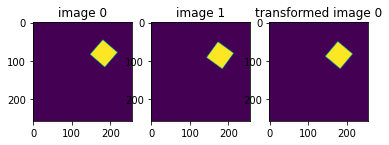

---- Network evaluation second iteration ----
7.1579056 -3.0481968 3.372939
---- Groundtruth ----
8 -4 5


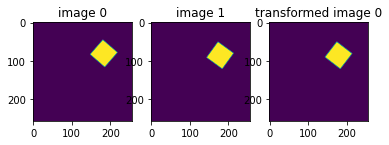

In [3]:
# choose an image in the dataset
i = 412

# let's dig into the dataset
im0 = dataset[i][0]
im1 = dataset[i][1]
obs = dataset[i][2]
x0 = dataset[i][2]['x0']
y0 = dataset[i][2]['y0']
angle0 = dataset[i][2]['angle0']
delta_x, delta_y, delta_angle = dataset[i][2]['transformation']

# we need to concatenate the two images as an input
input_net = torch.cat((im0,im1),0).unsqueeze(0)

print("---- Network evaluation first iteration ----")
results = model(input_net, obs, n_iterations=2)
delta_x_est, delta_y_est, delta_angle_est = results[f'iteration={1}']['transfo_output'][0][:].detach().numpy()
print(delta_x_est, delta_y_est, delta_angle_est)
print("---- Groundtruth ----")
print(delta_x, delta_y, delta_angle)
show_results(im0.numpy()[0,:,:], im1.numpy()[0,:,:], x0, y0, delta_x_est, delta_y_est, delta_angle_est)

print("---- Network evaluation second iteration ----")
delta_x_est, delta_y_est, delta_angle_est = results[f'iteration={2}']['transfo_output'][0][:].detach().numpy()
print(delta_x_est, delta_y_est, delta_angle_est)
print("---- Groundtruth ----")
print(delta_x, delta_y, delta_angle)
show_results(im0.numpy()[0,:,:], im1.numpy()[0,:,:], x0, y0, delta_x_est, delta_y_est, delta_angle_est)

# Monte Carlo Dropout 
Let's run a Monte Carlo dropout for covariance estimation

In [6]:
def monteCarloDropoutPredictions(input_net, model, obs, n):
  preds = np.zeros((n,3))
  model.train()
  for k in range(n):
    results = model(input_net, obs, n_iterations=2)
    preds[k,:] = results[f'iteration={2}']['transfo_output'][0][:].detach().numpy()
  return preds

def mean_and_cov(preds):
  # for np.cov: rows=variable, columns=datapoints
  return np.mean(preds, axis=0), np.cov(preds.T)

def monteCarloDropout(input_net, model, obs, n):
  preds = monteCarloDropoutPredictions(input_net, model, obs, n)
  return mean_and_cov(preds)

We evaluate the covariance on an adversarial example, with additional white noise

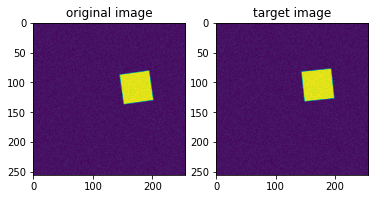

NN inference
[-5.01970962  0.72437346 -0.00963866]
Groundtruth
[-5 -2 -2]
Covariance
[[ 0.53420949 -0.06230256  0.22029019]
 [-0.06230256  0.32001295 -0.05331115]
 [ 0.22029019 -0.05331115  0.65024919]]


In [46]:
# choose an image in the dataset
i = 124

# let's dig into the dataset
sigma = 0.1
noise = sigma*torch.rand(256,256)
im0 = dataset[i][0] + noise
im1 = dataset[i][1] + noise
obs = dataset[i][2]

plt.subplot(1,2,1)
plt.imshow(im0.numpy()[0,:,:])
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(im1.numpy()[0,:,:])
plt.title('target image')
plt.show()


# we need to concatenate the two images as an input
input_net = torch.cat((im0,im1),0).unsqueeze(0)

mean, cov = monteCarloDropout(input_net, model, obs, 100)
print("NN inference")
print(mean)
print("Groundtruth")
print(dataset[i][2]['transformation'])
print("Covariance")
print(cov)

# Hessian based covariance estimation
Under the hypothesys of a gaussian output of the network and if we consider the output as the gradient of a loss function, we can deduce the covariance by the hessian computation

In [55]:
model.eval()

output = model(input_net, obs, n_iterations=2)
grad_NN = output['iteration=2']['model_output'].detach()
grad_NN_T = torch.transpose(grad_NN,0,1)
hessian_NN = grad_NN_T.matmul(grad_NN)
covariance_NN = torch.inverse(hessian_NN)
print('----output first iteration--------')
print(output['iteration=1']['transfo_output'].detach())
print('----groundtruth------')
print(dataset[i][2]['transformation'])
print('----covariance---')
print(covariance_NN)

----output first iteration--------
tensor([[-4.2441, -0.0938,  0.3779]])
----groundtruth------
[-5 -2 -2]
----covariance---
tensor([[-17926256.,  -4861240.,  35777856.],
        [  1613843.,  12829384.,  22798826.],
        [ 49374032.,  39409036., -43906888.]])
